In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
%pylab inline
pd.options.display.max_columns = 80


Populating the interactive namespace from numpy and matplotlib


In [3]:
df_price = pd.read_csv('../data/player_price.csv',',')
df_stats = pd.read_csv('../data/player_stats.csv',',')

In [4]:
df_price.head(5)

,timestamp,ps_price,xbox_price,player_id,player_name
0,1474588800000,0,0,1,Pelé
1,1474675200000,0,10000000,1,Pelé
2,1474761600000,0,0,1,Pelé
3,1474848000000,0,0,1,Pelé
4,1474934400000,0,10000000,1,Pelé


In [5]:
#df_stats.head(5)

In [6]:
# заменим rareness на 0,1
rareness = {'non-rare' : 0, 'rare' : 1}
df_stats['rareness'] = df_stats['rareness'].map(rareness)

In [7]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(["timestamp"], axis=1, inplace=True)
df_price['Year'], df_price['Month'] = df_price['Date'].dt.year, df_price['Date'].dt.month

In [8]:
#заменим для удобства название колонки с ценой
prices = df_price.drop(['ps_price'],axis = 1)
prices.rename(columns={'xbox_price':'price'}, inplace = True)

In [9]:
# to make name - unique
prices['Name_ID'] = prices['player_name'] + "_" +  prices['player_id'].astype(str)

In [10]:
prices.head(10)

,price,player_id,player_name,Date,Year,Month,Name_ID
0,0,1,Pelé,2016-09-23,2016,9,Pelé_1
1,10000000,1,Pelé,2016-09-24,2016,9,Pelé_1
2,0,1,Pelé,2016-09-25,2016,9,Pelé_1
3,0,1,Pelé,2016-09-26,2016,9,Pelé_1
4,10000000,1,Pelé,2016-09-27,2016,9,Pelé_1
5,0,1,Pelé,2016-09-28,2016,9,Pelé_1
6,9500000,1,Pelé,2016-09-29,2016,9,Pelé_1
7,8428000,1,Pelé,2016-09-30,2016,9,Pelé_1
8,8459091,1,Pelé,2016-10-01,2016,10,Pelé_1
9,7936136,1,Pelé,2016-10-02,2016,10,Pelé_1


In [11]:
# to estimate date range
(prices.Date.min(), prices.Date.max())

(Timestamp('2016-09-23 00:00:00'), Timestamp('2017-06-22 00:00:00'))

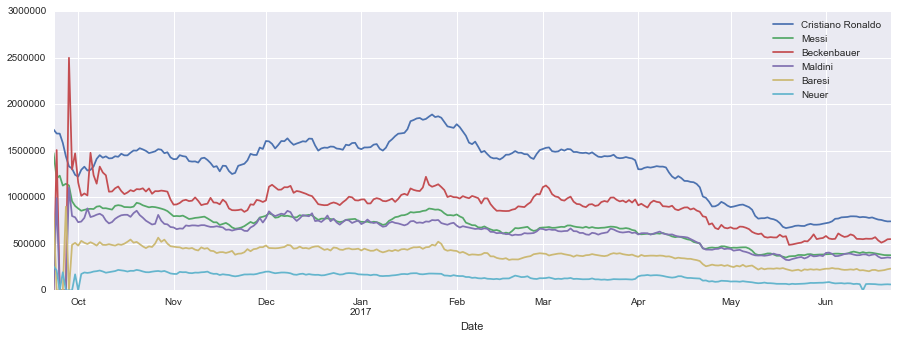

In [12]:
#Тестовый простой график для семи игроков
player_1 = (prices.player_id == 1)
player_2 = (prices.player_id == 2)
player_3 = (prices.player_id == 3)
player_4 = (prices.player_id == 4)
player_5 = (prices.player_id == 5)
player_6 = (prices.player_id == 6)
player_7 = (prices.player_id == 7)

plt.figure(figsize(15,5))

#ax = prices[player_1].plot(x = 'timestamp', y = 'price', label = prices[player_1].player_name.iloc[0])
ax = prices[player_2].plot(x = 'Date', y = 'price', label = prices[player_2].player_name.iloc[0])
prices[player_3].plot(x = 'Date', y = 'price', label = prices[player_3].player_name.iloc[0], ax = ax)
prices[player_4].plot(x = 'Date', y = 'price', label = prices[player_4].player_name.iloc[0], ax = ax)
prices[player_5].plot(x = 'Date', y = 'price', label = prices[player_5].player_name.iloc[0], ax = ax)
prices[player_6].plot(x = 'Date', y = 'price', label = prices[player_6].player_name.iloc[0], ax = ax)
prices[player_7].plot(x = 'Date', y = 'price', label = prices[player_7].player_name.iloc[0], ax = ax)
plt.show()

### Оценим разброс цен для топ дорогих игроков

In [13]:
players = prices.groupby(['player_id','Name_ID'])['price'].last().reset_index()
exp_players = players.loc[players["price"] > 1000000, "player_id"]

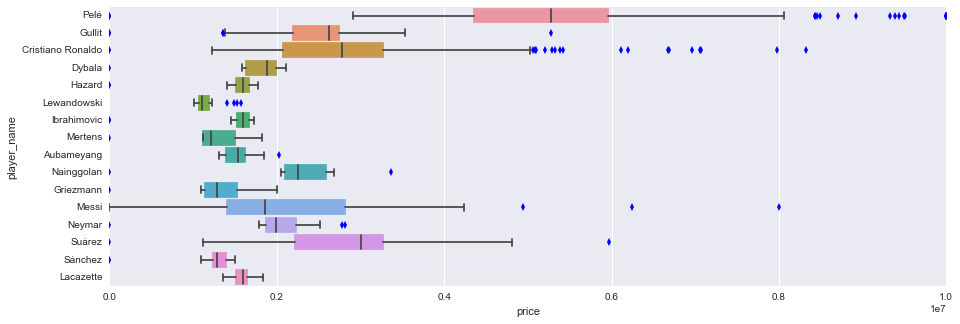

In [14]:
sns.boxplot(y = "player_name", x = "price", data=prices[prices.player_id.isin(exp_players)], orient="h")

## Let's Plotly!

In [15]:
'''
To show some thechnics to build interactive plots with Ploty

- in case you faces the error "Notebook format bla bla bla....." please do:
pip install --upgrade nbformat

- in case widjets wount work:
pip install ipywidgets --upgrade
'''
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from ipywidgets import widgets, interact
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

In [16]:
init_notebook_mode(connected=True)

In [17]:
club_names_dropdown = widgets.Dropdown()
club_names_dropdown.options  = [name for name in df_stats['club'].unique()]
club_names_dropdown.value = 'Real Madrid'
club_names_dropdown.description = 'Select Club Name'

In [18]:
def select_player_names(club):
    players_in_club = players.player_id.isin(df_stats[df_stats.club == club].player_id)
    player_names_dropdown.options =  [name for name in players[players_in_club].Name_ID.sort_values()]                                      
    player_names_dropdown.value = (player_names_dropdown.options[0],) 
    player_names_dropdown.description = 'Select players name'

    
player_names_dropdown = widgets.SelectMultiple()
select_player_names('Real Madrid')

In [19]:
def view_image(player_name):
    data=[]
    
    for name in player_name:
        df = prices[prices.Name_ID == name]
        trace = go.Scatter(x=df.Date,
                           y=df.price,
                           name = name
                          )
        data.append(trace)
    
    layout = dict(
        title='Player price: ' + ', '.join(player_name),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='2017 Only',
                        step='year',
                        stepmode='todate'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(thickness = 0.1),
            type='date'
        )
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)


In [20]:
i = widgets.interactive(select_player_names, club = club_names_dropdown)
j = widgets.interactive(view_image, player_name = player_names_dropdown)
display(i)
display(j)
# You can select multiple items

# Анализ времменых рядов

In [21]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [22]:
# код для отрисовки графиков
def tsplot(df, lags=None, figsize=(12, 7), style='bmh'):
   
    if not isinstance(df, pd.Series):
        y = df['price']
        y.index = df.Date
    else:
         y = df
            
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 
     
    

Критерий Дики-Фуллера: p=0.784437


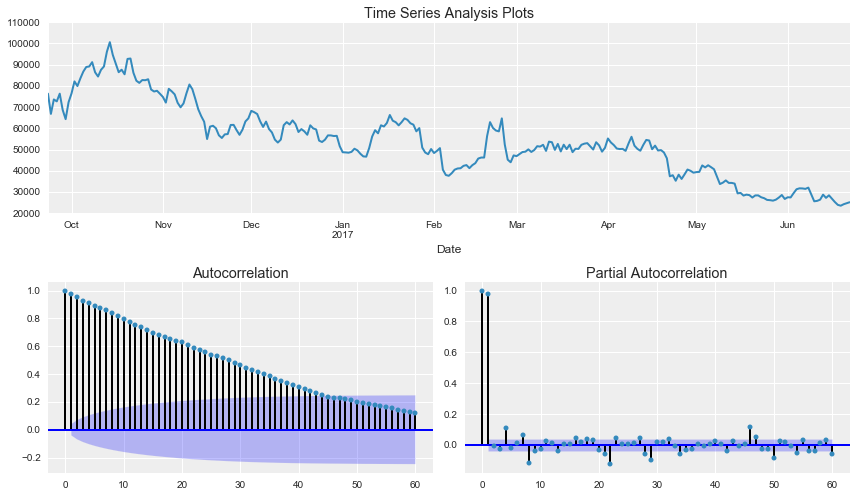

In [23]:
tsplot(prices[prices.Name_ID == 'Modric_42'], lags=60)

Исходный ряд не является стационарным (согласно визуальному анализу а также критерия Дики-Фуллера)
Cезонность не просматривается


### Проведем STL- декомпозицию

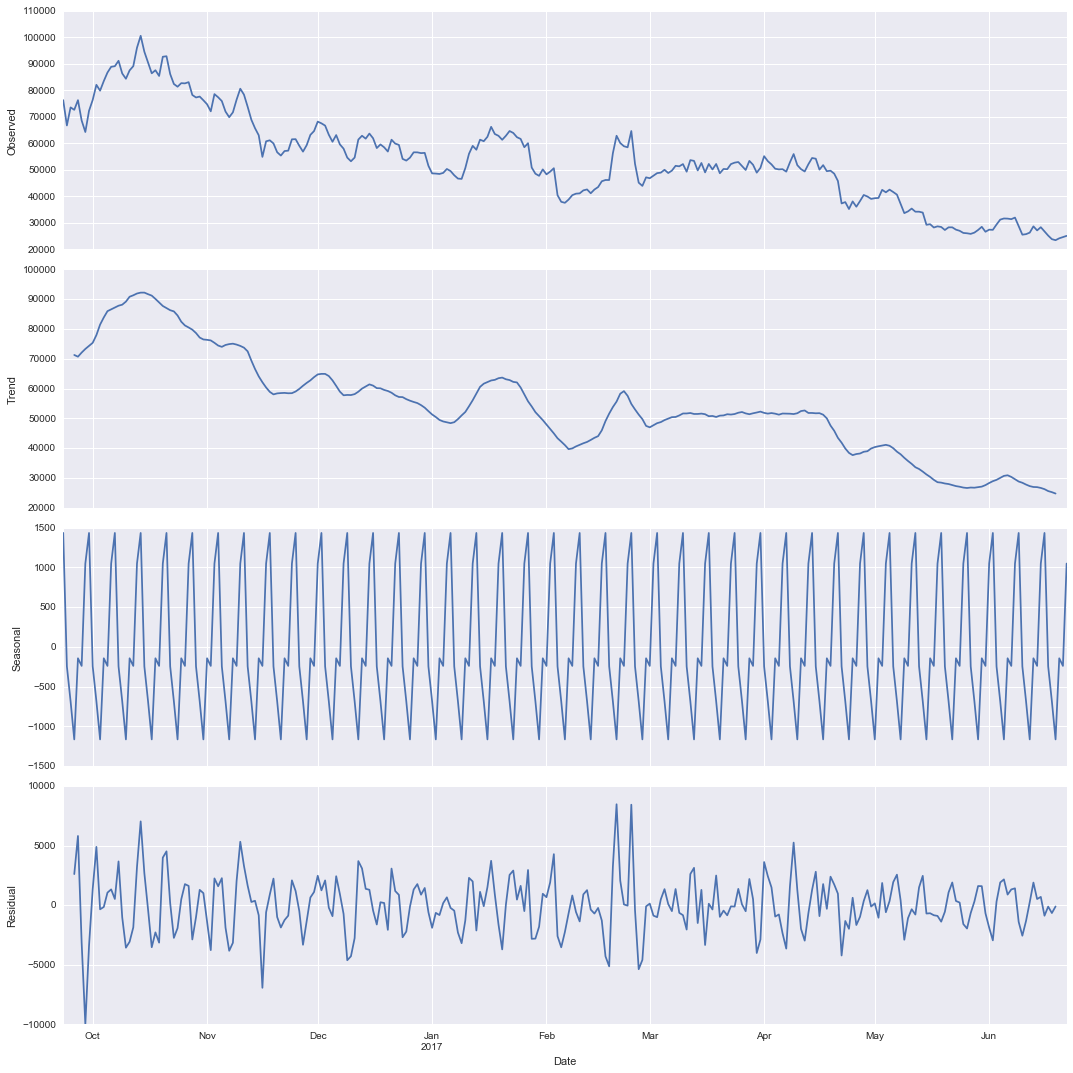

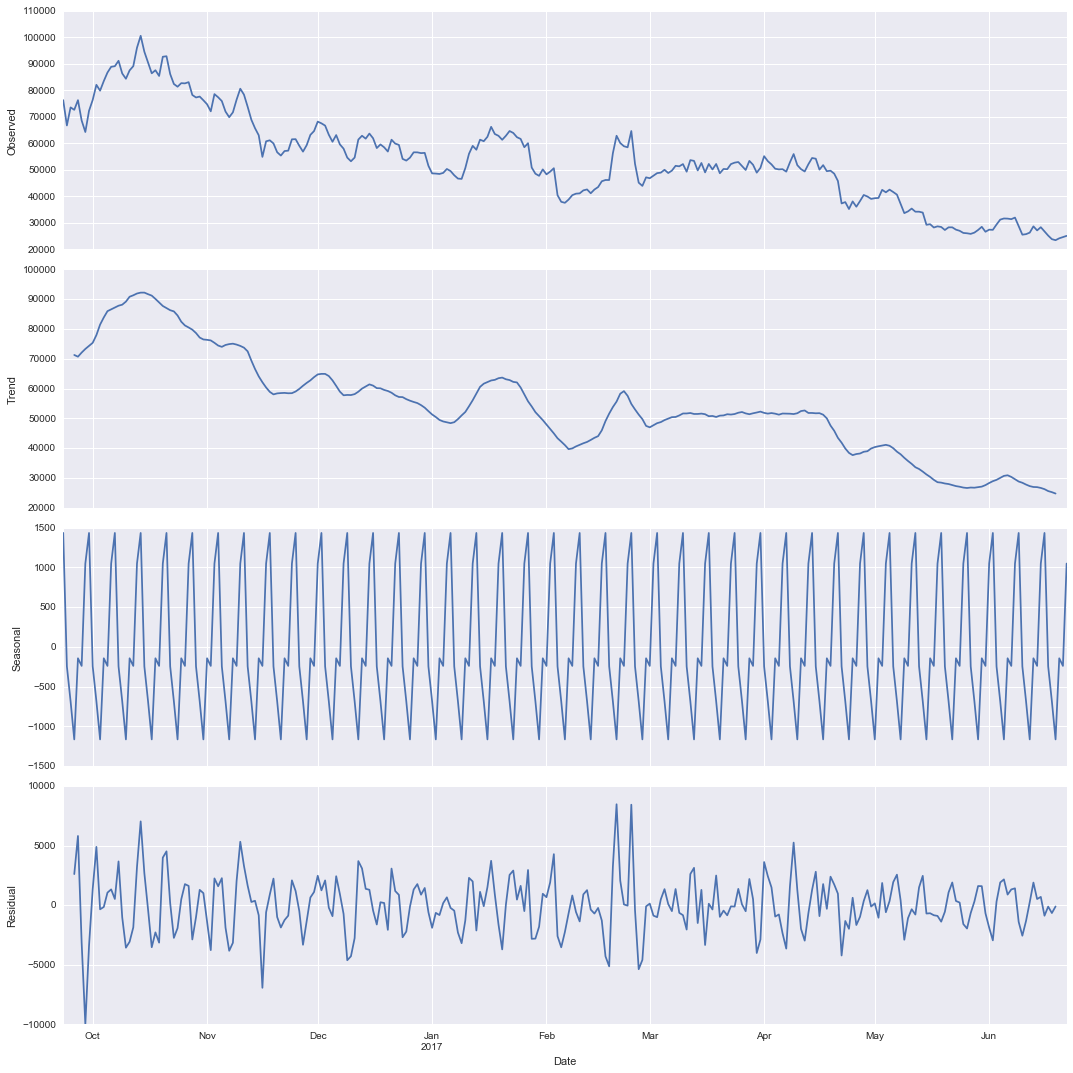

In [24]:
plt.figure(figsize(15,15))
y = prices[prices.Name_ID == 'Modric_42'].price
y.index = prices[prices.Name_ID == 'Modric_42'].Date
sm.tsa.seasonal_decompose(y).plot()

Видим явный тренд

# Анализ выбоки с статистическими данными

## Разделим признаки на группы

In [25]:
date_features = ["added_on"]
discrete_features = ['intl_reputation','skills','weak_foot']
gk_real_features = ['diving','handling','kicking','reflexes','speed']
fp_real_features = ['defending','pace','passing','physicality','shooting']
cat_features = ["raits", "specialities",  "att_workrate", "club", "def_workrate","foot",
                "league", "nation", "origin", "revision","colour","front_scores",
                "position", "rareness"]

real_features = df_stats.columns.drop(cat_features + discrete_features + gk_real_features + fp_real_features + \
                                      ['player_id','name']).tolist()

#Пока непонятно как использовать это raits
cat_features.remove('raits')

## Построим распределение средних цен по клубам

In [26]:
prices_clubs = prices.merge(df_stats[['club','player_id']], on = ['player_id'], how = 'inner')

In [27]:
#строим на последнюю доступную дату
date_last = pd.to_datetime('2017-06-19')

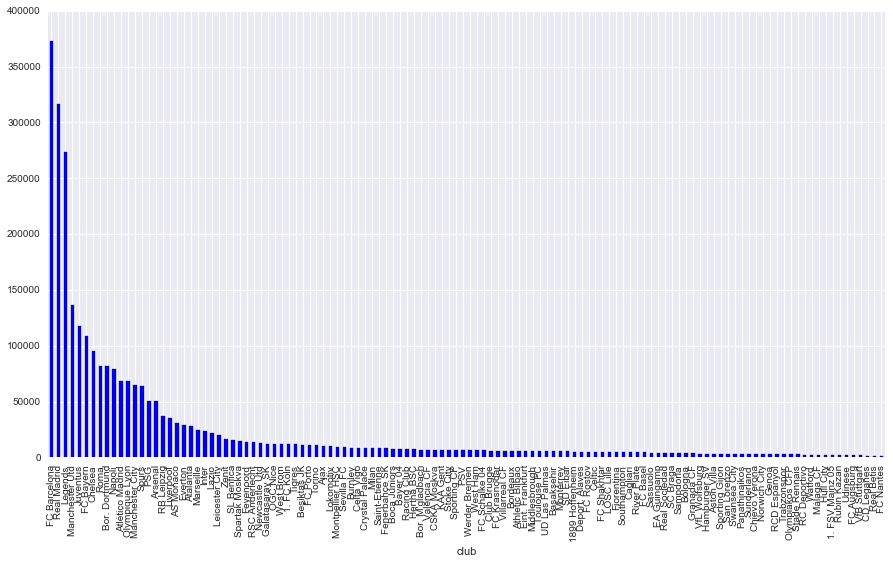

In [28]:
plt.figure(figsize(15,8))
prices_clubs[prices_clubs.Date == date_last].groupby('club')['price'].mean().sort_values(ascending = False).plot(kind = 'bar')

** Видим что клуб сильно влияет на цену игрока **

In [29]:
#Добавим в статистику цену
stats_w_last_price = df_stats.merge(prices[prices.Date == date_last], on =['player_id'], how = 'inner')

## Построим распределение средних цен в зависимости от позиции  на поле

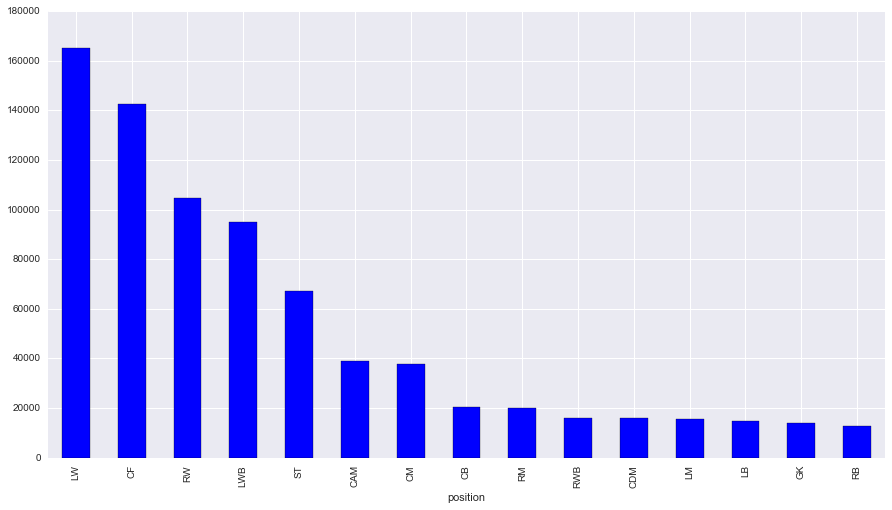

In [30]:
positions =['CF', 'CB', 'LB', 'LF','RF','CDM','ST','GK', 'CM', 'RW','RWB', 'LM','CAM','RB','LWB','RM','LW']
stats_w_last_price[stats_w_last_price.position.isin(positions)].groupby('position')['price'].mean().sort_values(ascending = False).plot(kind = 'bar')

#### А что если удалить супер дорогих игроков?

In [31]:
# filter the very expensive players
not_exp_players = (stats_w_last_price.price < 1000000)

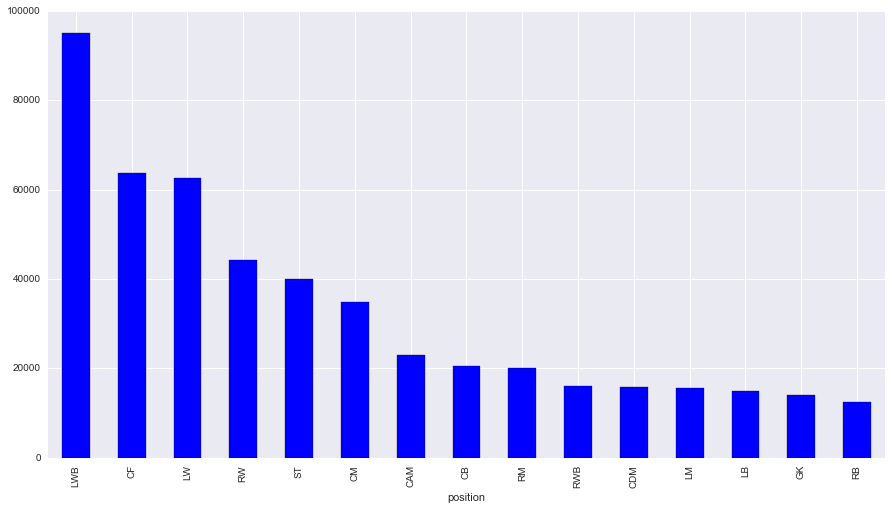

In [32]:
stats_w_last_price[stats_w_last_price.position.isin(positions) & not_exp_players].groupby('position')['price'].mean().sort_values(ascending = False).plot(kind = 'bar')

## Построим распределение средних цен в зависимости от редкости карточки


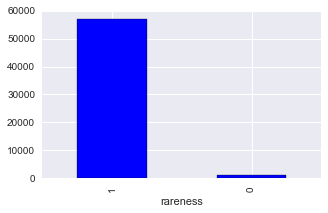

In [33]:
plt.figure(figsize(5,3))
stats_w_last_price.groupby('rareness')['price'].mean().sort_values(ascending = False).plot(kind = 'bar')

*** Стоимость сильно зависит от редкости карточки ***

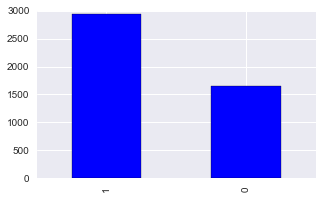

In [34]:
stats_w_last_price.rareness.value_counts().plot(kind='bar', label='Редкость карточки')


*** Редких карточек больше? ***

## Изучим числовые признаки

### Строим гистограммы

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011997390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001C412B38>]], dtype=object)

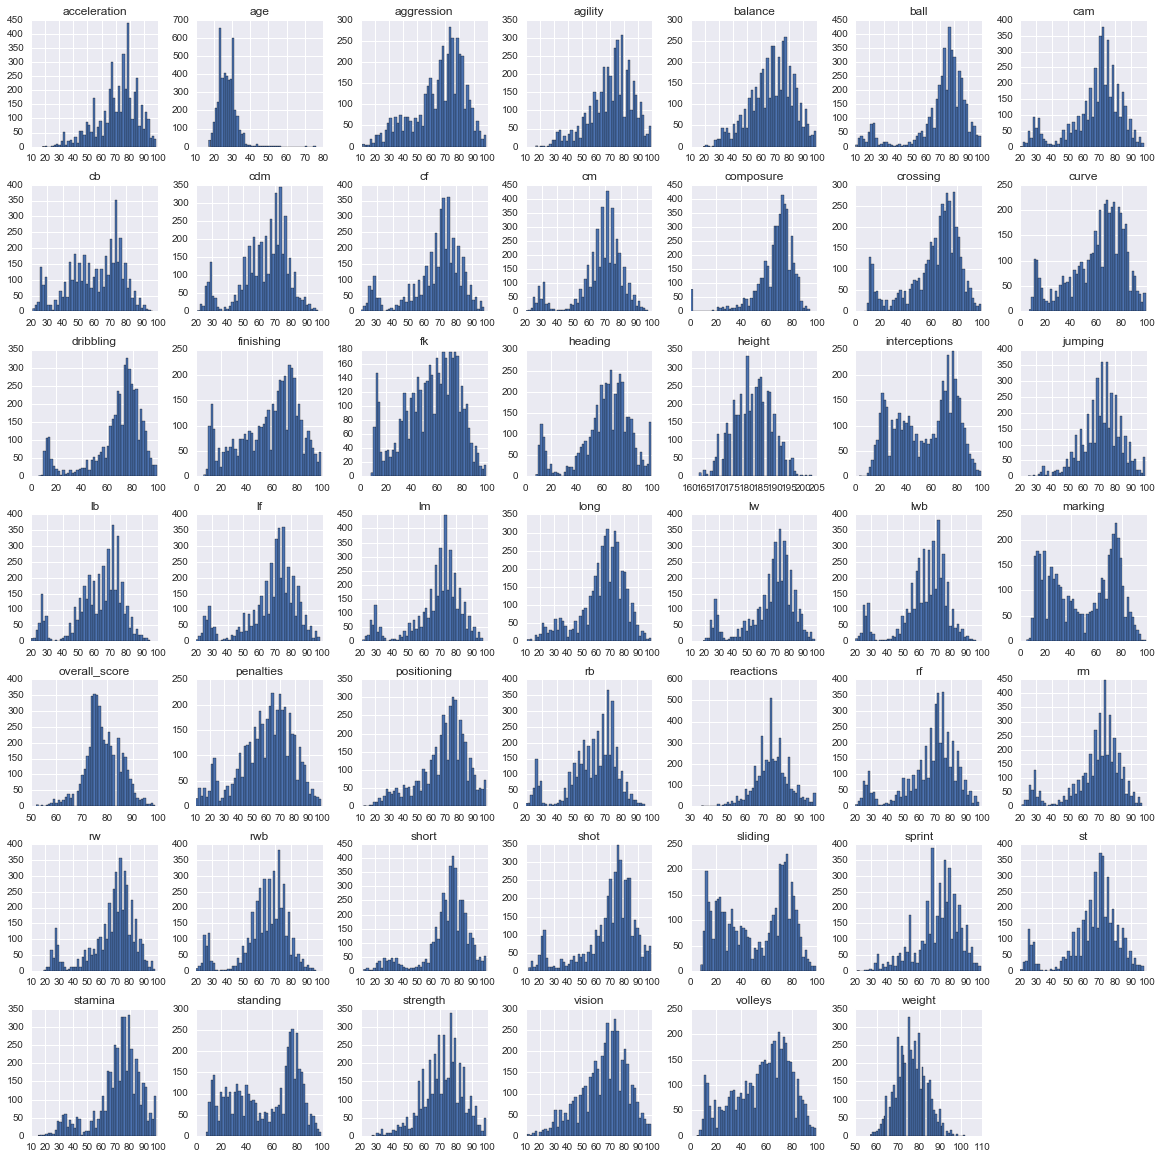

In [35]:
stats_w_last_price.hist(column=real_features,figsize=(20,20), bins = 50)

*** Не все признаки имеют нормальное распределение ***

### Строим попарные распределения - ищем зависимые признаки

In [36]:
# ограничим количество колонок - выбросим колонки со специальными навыками
special_features = ['cam','cdm','cb','cf','cm','lb','lf','lm','lw','lwb','rw','rb','rm','rf','rwb','st']
columns = list(set(real_features + ['price']) - set(special_features) - set(['height','weight','age']))

In [37]:
#!!!! Эта ячейка довольно долго считается. Дважды подумайте нужно ли Вам ее запускать.
# Для запуска раскоментируйте строки. А можно просто посмотреть на готовый файл.

#sns_plot = sns.pairplot(stats_w_last_price[columns])  
#sns_plot.savefig("Pairplot_real_features.png")
from IPython.display import Image
Image(url= "Pairplot_real_features.png")


# Double click for bigger view

**** При рассмотреннии паирплота можно заметить: ****

1) Цена игрока зависит от: overal_score, finishing, positioning, reactions, sprint, ball, stamina,
   short, agility, dribling, balance, curve, penalties, strength, fk, vision, acceleration,
    crossing, shot, voleys
            
            
2)Имеют признаки линейной зависимости (нужно перепроверять другими методами):
             marking - sliding, sliding - standing,  sprint - acceleration,
             overalscore - reactions, standing - marking
                        
            



** Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед построением модели. **

In [38]:
corr_matrix  = stats_w_last_price[columns].corr()

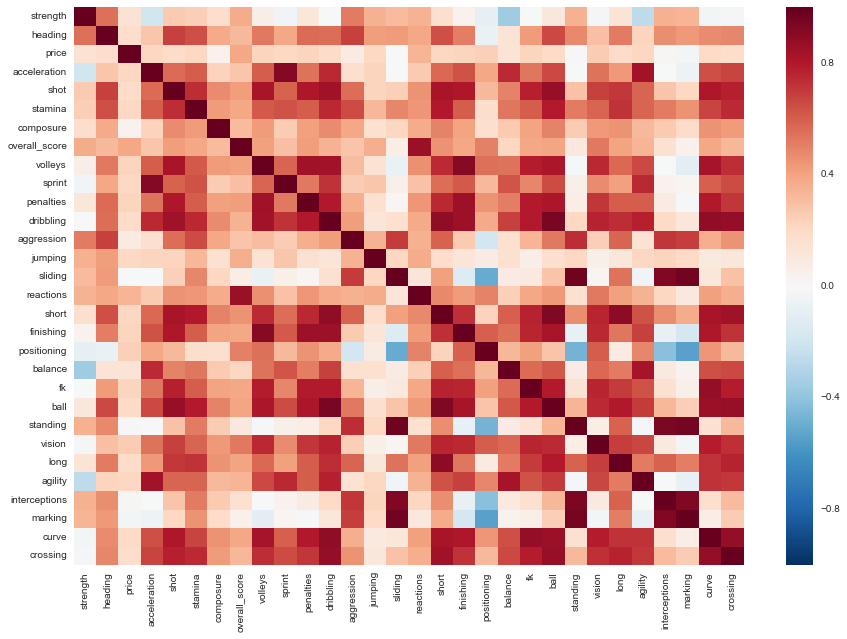

In [39]:
plt.figure(figsize(15,10))
sns.heatmap(corr_matrix)

*** Кандидаты на выброс (одиного из них): ***
 - interseptions-marking
 - interseptions-sliding
 - finishing - penalties
 - shot - volley
 - standing -sliding
 - dribbling - ball
 - sliding - marking
 - sprint - fk
 

## Признаки специфические для players at different positions

ToDo

## Признаки специфические для Field player и GK

ToDo

## Категориальные признаки

#### Посчитаем количесво значений для каждого категориального признака

In [57]:
columns1 = cat_features[:] 
columns1.remove('specialities')
columns1.remove('front_scores')
columns1.remove('origin')
columns1.remove('league')
columns1.remove('club')
columns1.remove('nation')

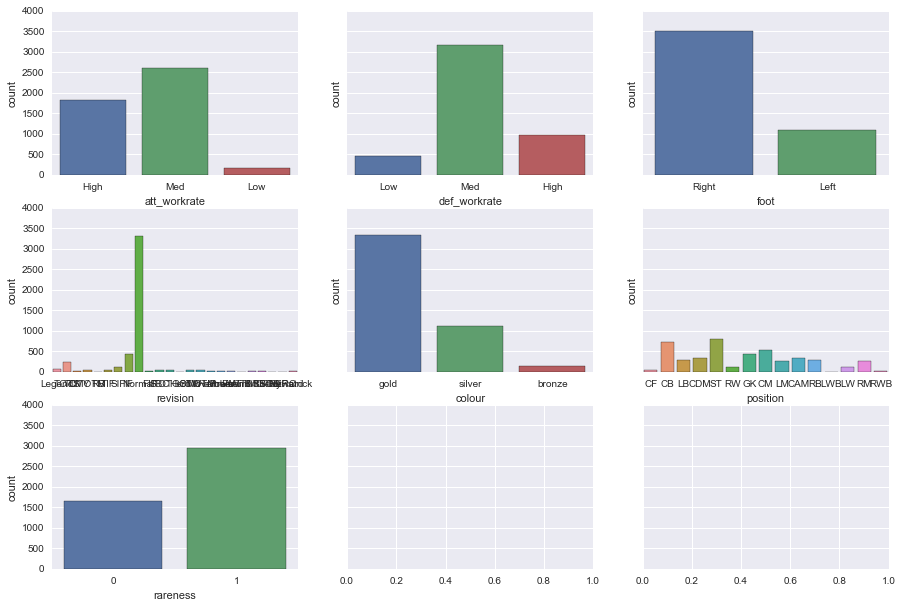

In [60]:
fig, axes = plt.subplots(3, 3, sharey=True)
for i in range(len(columns1)):
    sns.countplot(x=columns1[i], data=stats_w_last_price, ax=axes[int(i / 3), i % 3])



### Признак revision имеет сильный перекос - возможно это нужно будет учитывать